In [3]:
import os
from pathlib import Path

os.environ['MMWHS_CACHE_PATH'] = str(Path('.', '.cache'))

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.cuda.amp as amp

from tqdm import tqdm
import wandb
import nibabel as nib

from slice_inflate.datasets.mmwhs_dataset import MMWHSDataset, load_data, extract_2d_data
from slice_inflate.utils.common_utils import DotDict, get_script_dir
from slice_inflate.utils.torch_utils import reset_determinism, ensure_dense, get_batch_dice_over_all, get_batch_dice_per_class, save_model
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from slice_inflate.datasets.align_mmwhs import cut_slice
from slice_inflate.utils.log_utils import get_global_idx, log_class_dices
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader

from mdl_seg_class.metrics import dice3d
import numpy as np
THIS_SCRIPT_DIR = get_script_dir()

In [2]:
config_dict = DotDict({
    'num_folds': 5,
    'only_first_fold': True,                # If true do not contiue with training after the first fold
    # 'fold_override': 0,
    # 'checkpoint_epx': 0,

    'use_mind': False,                      # If true use MIND features (https://pubmed.ncbi.nlm.nih.gov/22722056/)
    'epochs': 100,

    'batch_size': 4,
    'val_batch_size': 1,
    'modality': 'mr',
    'use_2d_normal_to': None,               # Can be None or 'D', 'H', 'W'. If not None 2D slices will be selected for training

    'dataset': 'mmwhs',                 # The dataset prepared with our preprocessing scripts
    'data_base_path': str(Path(THIS_SCRIPT_DIR, "data/MMWHS")),
    'reg_state': None, # Registered (noisy) labels used in training. See prepare_data() for valid reg_states
    'train_set_max_len': None,              # Length to cut of dataloader sample count
    'crop_around_3d_label_center': (128,128,128),
    'crop_3d_region': ((0,128), (0,128), (0,128)),        # dimension range in which 3D samples are cropped
    'crop_2d_slices_gt_num_threshold': 0,   # Drop 2D slices if less than threshold pixels are positive

    'lr': 0.001,
    'use_scheduling': True,

    'save_every': 'best',
    'mdl_save_prefix': 'data/models',

    'debug': False,
    'wandb_mode': 'online',                         # e.g. online, disabled. Use weights and biases online logging
    'do_sweep': False,                                # Run multiple trainings with varying config values defined in sweep_config_dict below

    # For a snapshot file: dummy-a2p2z76CxhCtwLJApfe8xD_fold0_epx0
    'checkpoint_name': None,                          # Training snapshot name, e.g. dummy-a2p2z76CxhCtwLJApfe8xD
    'fold_override': None,                            # Training fold, e.g. 0
    'checkpoint_epx': None,                           # Training epx, e.g. 0

    'do_plot': False,                                 # Generate plots (debugging purpose)
    'save_dp_figures': False,                         # Plot data parameter value distribution
    'save_labels': True,                              # Store training labels alongside data parameter values inside the training snapshot

    'device': 'cuda'
})

In [3]:
class BlendowskiAE(torch.nn.Module):

    class ConvBlock(torch.nn.Module):
        def __init__(self, in_channels: int, out_channels_list: list, strides_list: list):
            super().__init__()

            ops = []
            in_channels = [in_channels] + out_channels_list[:-1]
            for op_idx in range(len(out_channels_list)):
                ops.append(torch.nn.Conv3d(
                    in_channels[op_idx],
                    out_channels_list[op_idx],
                    kernel_size=3,
                    stride=strides_list[op_idx],
                    padding=1
                ))

            self.block = torch.nn.Sequential(*ops)

        def forward(self, x):
            return self.block(x)



    def __init__(self, in_channels, out_channels, decoder_in_channels=2, debug_mode=False):
        super().__init__()

        self.debug_mode = debug_mode

        self.first_layer_encoder = self.ConvBlock(in_channels, out_channels_list=[8], strides_list=[1])
        self.first_layer_decoder = self.ConvBlock(8, out_channels_list=[8,out_channels], strides_list=[1,1])

        self.second_layer_encoder = self.ConvBlock(8, out_channels_list=[20,20,20], strides_list=[2,1,1])
        self.second_layer_decoder = self.ConvBlock(20, out_channels_list=[8], strides_list=[1])

        self.third_layer_encoder = self.ConvBlock(20, out_channels_list=[40,40,40], strides_list=[2,1,1])
        self.third_layer_decoder = self.ConvBlock(40, out_channels_list=[20], strides_list=[1])

        self.fourth_layer_encoder = self.ConvBlock(40, out_channels_list=[60,60,60], strides_list=[2,1,1])
        self.fourth_layer_decoder = self.ConvBlock(decoder_in_channels, out_channels_list=[40], strides_list=[1])

        self.fifth_layer = self.ConvBlock(60, out_channels_list=[60,20,2], strides_list=[2,1,1])

        self.encoder = torch.nn.Sequential(
            self.first_layer_encoder,
            self.second_layer_encoder,
            self.third_layer_encoder,
            self.fourth_layer_encoder,
            self.fifth_layer
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Upsample(scale_factor=2),
            self.fourth_layer_decoder,
            torch.nn.Upsample(scale_factor=2),
            self.third_layer_decoder,
            torch.nn.Upsample(scale_factor=2),
            self.second_layer_decoder,
            torch.nn.Upsample(scale_factor=2),
            self.first_layer_decoder,
        )

    def encode(self, x):
        if self.debug_mode:
            return debug_forward_pass(self.encoder, x, STEP_MODE=False)
        else:
            return self.encoder(x)

    def decode(self, z):
        if self.debug_mode:
            return debug_forward_pass(self.decoder, z, STEP_MODE=False)
        else:
            return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z), z



class BlendowskiVAE(BlendowskiAE):
    def __init__(self, *args, **kwargs):
        kwargs['decoder_in_channels'] = 1
        super().__init__(*args, **kwargs)

    def sample_z(self, mean, std):
        return torch.normal(mean=mean, std=std).unsqueeze(1)

    def forward(self, x):
        h = self.encode(x)
        z = self.sample_z(h[:,0], (h[:,1]**2).sqrt())
        return self.decode(z), z

In [4]:
def get_model(config, dataset_len, num_classes, THIS_SCRIPT_DIR, _path=None, device='cpu'):
    _path = Path(THIS_SCRIPT_DIR).joinpath(_path).resolve()

    model = BlendowskiAE(in_channels=num_classes, out_channels=num_classes)

    model.to(device)
    print(f"Param count model: {sum(p.numel() for p in model.parameters())}")

    optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr)
    scaler = amp.GradScaler()

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20, verbose=True)

    if _path and _path.is_dir():
        print(f"Loading model, optimizers and grad scalers from {_path}")
        model.load_state_dict(torch.load(_path.joinpath('model.pth'), map_location=device))
        optimizer.load_state_dict(torch.load(_path.joinpath('optimizer.pth'), map_location=device))
        scheduler.load_state_dict(torch.load(_path.joinpath('scheduler.pth'), map_location=device))
        scaler.load_state_dict(torch.load(_path.joinpath('scaler.pth'), map_location=device))
    else:
        print(f"Generating fresh '{type(model).__name__}' model, optimizer and grad scaler.")

    return (model, optimizer, scheduler, scaler)

In [5]:
def prepare_data(config):
    training_dataset = MMWHSDataset(
        config.data_base_path,
        state="training",
        load_func=load_data,
        extract_slice_func=extract_2d_data,
        modality=config.modality,
        do_align_global=True,
        do_resample=False, # Prior to cropping, resample image?
        crop_3d_region=None, # Crop or pad the images to these dimensions
        crop_around_3d_label_center=config.crop_around_3d_label_center,
        pre_interpolation_factor=1., # When getting the data, resize the data by this factor
        ensure_labeled_pairs=True, # Only use fully labelled images (segmentation label available)
        use_2d_normal_to=config.use_2d_normal_to, # Use 2D slices cut normal to D,H,>W< dimensions
        crop_around_2d_label_center=(128,128),

        augment_angle_std=5,

        device=config.device,
        debug=config.debug
    )

    return training_dataset

training_dataset = prepare_data(config_dict)

Loading MMWHS training images and labels... (['mr'])


20 images, 20 labels: 100%|██████████| 40/40 [00:26<00:00,  1.49it/s]


Postprocessing 3D volumes
Removed 0 3D images in postprocessing
Equal image and label numbers: True (20)
Data import finished.
Dataloader will yield 3D samples


In [6]:
model_path = "data/models/solar-vortex-7_fold0_best"
(model, optimizer, scheduler, scaler) = get_model(config_dict, len(training_dataset), len(training_dataset.label_tags),
    THIS_SCRIPT_DIR=Path(THIS_SCRIPT_DIR), _path=model_path, device=config_dict.device)

Param count model: 556732
Loading model, optimizers and grad scalers from /share/data_supergrover1/weihsbach/shared_data/tmp/slice_inflate/data/models/solar-vortex-7_fold0_best


In [7]:
def get_model_input_from_sample(sample, config, num_classes):
    b_hla_slc_seg = sample['hla_label_slc'].unsqueeze(0)
    b_sa_slc_seg = sample['sa_label_slc'].unsqueeze(0)
    b_input = torch.cat(
        [b_sa_slc_seg.unsqueeze(1).repeat(1,64,1,1),
            b_hla_slc_seg.unsqueeze(1).repeat(1,64,1,1)],
            dim=1
    )
    b_seg = sample['label'].unsqueeze(0)

    b_input = b_input.to(device=config.device)
    b_seg = b_seg.to(device=config.device)

    b_input = F.one_hot(b_input, num_classes).permute(0,4,1,2,3)
    b_input = b_input.float()

    return b_input, b_seg

def inference_wrap(model, b_seg):
    with torch.inference_mode():
        b_out = model(b_seg)[0]
        b_out = b_out.argmax(1)
        return b_out

In [13]:
training_dataset.eval()

for sample in [training_dataset[_id] for _id in ['1001-mr', '1002-mr', '1003-mr', '1004-mr']]:
    b_input, b_seg = get_model_input_from_sample(sample, config_dict, len(training_dataset.label_tags))
    b_output = inference_wrap(model, b_input)

    nib.save(nib.Nifti1Image(b_output.squeeze(0).cpu().int().numpy(), np.eye(4,4)), f"{sample['id']}_pred.nii.gz")
    nib.save(nib.Nifti1Image(sample['label'].cpu().int().numpy(), np.eye(4,4)), f"{sample['id']}_target.nii.gz")
    nib.save(nib.Nifti1Image(sample['image'].cpu().numpy(), np.eye(4,4)), f"{sample['id']}_image.nii.gz")


# Create meshes

In [1]:
from slice_inflate.utils.common_utils import DotDict, get_script_dir
import os
os.environ['MMWHS_CACHE_PATH'] = ".cache"
from slice_inflate.datasets.mmwhs_dataset import MMWHSDataset, load_data, extract_2d_data
import torch
from pathlib import Path 

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from skimage import measure
from skimage.draw import ellipsoid

THIS_SCRIPT_DIR = get_script_dir()

config_dict = DotDict({
    'num_folds': 5,
    'only_first_fold': True,                # If true do not contiue with training after the first fold
    # 'fold_override': 0,
    # 'checkpoint_epx': 0,
                   # If true use MIND features (https://pubmed.ncbi.nlm.nih.gov/22722056/)
    'epochs': 500,

    'batch_size': 4,
    'val_batch_size': 1,
    'modality': 'mr',
    'use_2d_normal_to': None,               # Can be None or 'D', 'H', 'W'. If not None 2D slices will be selected for training

    'dataset': 'mmwhs',                 # The dataset prepared with our preprocessing scripts
    'data_base_path': str(Path(THIS_SCRIPT_DIR, "data/MMWHS")),
    'reg_state': None, # Registered (noisy) labels used in training. See prepare_data() for valid reg_states
    'train_set_max_len': None,              # Length to cut of dataloader sample count
    'crop_around_3d_label_center': (128,128,128),
    'crop_3d_region': ((0,128), (0,128), (0,128)),        # dimension range in which 3D samples are cropped
    'crop_2d_slices_gt_num_threshold': 0,   # Drop 2D slices if less than threshold pixels are positive

    'lr': 1e-3,
    'use_scheduling': True,

    'save_every': 'best',
    'mdl_save_prefix': 'data/models',

    'debug': False,
    'wandb_mode': 'online',                         # e.g. online, disabled. Use weights and biases online logging
    'do_sweep': False,                                # Run multiple trainings with varying config values defined in sweep_config_dict below

    # For a snapshot file: dummy-a2p2z76CxhCtwLJApfe8xD_fold0_epx0
    'checkpoint_name': None,                          # Training snapshot name, e.g. dummy-a2p2z76CxhCtwLJApfe8xD
    'fold_override': None,                            # Training fold, e.g. 0
    'checkpoint_epx': None,                           # Training epx, e.g. 0

    'do_plot': False,                                 # Generate plots (debugging purpose)
    'save_dp_figures': False,                         # Plot data parameter value distribution
    'save_labels': True,                              # Store training labels alongside data parameter values inside the training snapshot

    'device': 'cuda'
})

In [2]:
def prepare_data(config):
    training_dataset = MMWHSDataset(
        config.data_base_path,
        state="training",
        load_func=load_data,
        extract_slice_func=extract_2d_data,
        modality=config.modality,
        do_align_global=True,
        do_resample=False, # Prior to cropping, resample image?
        crop_3d_region=None, # Crop or pad the images to these dimensions
        crop_around_3d_label_center=config.crop_around_3d_label_center,
        pre_interpolation_factor=1., # When getting the data, resize the data by this factor
        ensure_labeled_pairs=True, # Only use fully labelled images (segmentation label available)
        use_2d_normal_to=config.use_2d_normal_to, # Use 2D slices cut normal to D,H,>W< dimensions
        crop_around_2d_label_center=(128,128),

        augment_angle_std=5,

        device=config.device,
        debug=config.debug
    )

    return training_dataset

training_dataset = prepare_data(config_dict)

Loading MMWHS training images and labels... (['mr'])


20 images, 20 labels: 100%|██████████| 40/40 [00:16<00:00,  2.44it/s]


Postprocessing 3D volumes
Removed 0 3D images in postprocessing
Equal image and label numbers: True (20)
Data import finished.
Dataloader will yield 3D samples


NameError: name 'first_class' is not defined

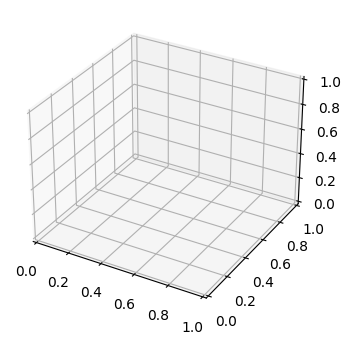

In [3]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111, projection='3d')
# Use marching cubes to obtain the surface mesh of these ellipsoids
sp = 1.0
verts, faces, normals, values = measure.marching_cubes(first_class.cpu().numpy(), spacing=(sp,sp,sp), step_size=4)

mesh = Poly3DCollection(verts[faces])
mesh.set_edgecolor('k')
ax.add_collection3d(mesh)

ax.set_xlim(0, 128)
ax.set_ylim(0, 128)
ax.set_zlim(0, 128)

plt.tight_layout()
plt.show()

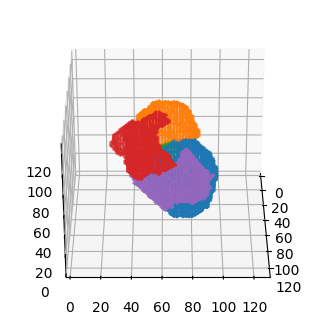

In [11]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(projection='3d')

sample = training_dataset[0]
label = torch.nn.functional.one_hot(sample['label'], len(training_dataset.label_tags))

SPACING = (1,1,1)
STEP_SIZE = 2

for class_idx, tag in enumerate(training_dataset.label_tags):
    if class_idx == 0: continue

    sub_label = label[:,:,:,class_idx]
    verts, faces, normals, values = measure.marching_cubes(sub_label.cpu().numpy(), spacing=SPACING, step_size=STEP_SIZE)
    ax.scatter(verts[:,0], verts[:,1], verts[:,2], s=1)

ax.set_xlim(0, 128)
ax.set_ylim(0, 128)
ax.set_zlim(0, 128)

import numpy as np
from matplotlib.animation import FuncAnimation
from IPython import display
import matplotlib.pyplot as plt

def anim_func(frame):
    angle = frame
    ax.view_init(30, angle)

plt.rcParams['animation.ffmpeg_path'] = "/home/weihsbach/miniconda3/envs/binaries/bin/ffmpeg"

anim_created = FuncAnimation(fig, anim_func, frames=360, interval=25)
display.display(display.HTML(anim_created.to_html5_video()))


In [48]:
plane_points = torch.tensor([201., 200., 10.])
n = plane_points/(plane_points[0]**2+plane_points[1]**2+plane_points[2]**2).sqrt()

In [49]:
dists = torch.zeros(len(verts))

for idx, v in enumerate(verts):
    v = torch.as_tensor(v.copy())
    dists[idx] = v.dot(n).abs()

In [51]:
dists.min()

tensor(72.1574)

shaperformer

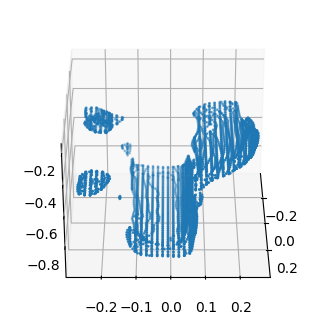

In [7]:
shapeformer_data = np.load("/share/data_supergrover1/weihsbach/shared_data/tmp/ShapeFormer/out.npy")

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(projection='3d')

SPACING = (1,1,1)
STEP_SIZE = 2

verts = shapeformer_data
ax.scatter(verts[:,0], verts[:,1], verts[:,2], s=1)

import numpy as np
from matplotlib.animation import FuncAnimation
from IPython import display
import matplotlib.pyplot as plt

def anim_func(frame):
    angle = frame
    ax.view_init(30, angle)

plt.rcParams['animation.ffmpeg_path'] = "/home/weihsbach/miniconda3/envs/binaries/bin/ffmpeg"

anim_created = FuncAnimation(fig, anim_func, frames=360, interval=25)
display.display(display.HTML(anim_created.to_html5_video()))
